<a href="https://colab.research.google.com/github/miguelpnonato/miguelpnonato/blob/main/chapter_multilayer-perceptrons/mlp-implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In the code below we use `nn.Parameter`
to automatically register
a class attribute as a parameter to be tracked by `autograd` (:numref:`sec_autograd`).


In [3]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

### Model

To make sure we know how everything works,
we will [**implement the ReLU activation**] ourselves
rather than invoking the built-in `relu` function directly.


In [4]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

Since we are disregarding spatial structure,
we `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.
Finally, we (**implement our model**)
with just a few lines of code. Since we use the framework built-in autograd this is all that it takes.


In [5]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, and trainer, then finally invoke the `fit` method on model and data.


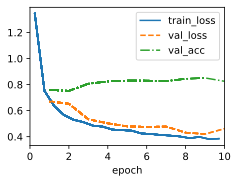

In [11]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.


In [9]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class (:numref:`subsec_oo-design-models`) to
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.
We will further discuss how the `Sequential` class works in :numref:`subsec_model-construction-sequential`.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


In [10]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

NameError: name 'trainer' is not defined

## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.
1. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?
1. Measure the speed of tensor--matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
    1. How does this change between GPUs and CPUs?
    1. Determine the memory bus width of your CPU and GPU.
1. Try out different activation functions. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?


# Resoluçao da Atividade - Miguel Pedrosa

Criaçao dos 3 modelos com diferentes números de neurônios escondidos

In [6]:
model_128 = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=128, lr=0.1)
model_512 = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=512, lr=0.1)
model_1024 = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=1024, lr=0.1)


Treinando os modelos criados

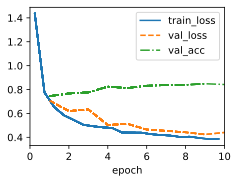

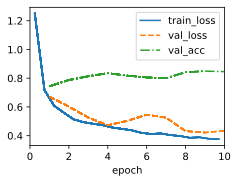

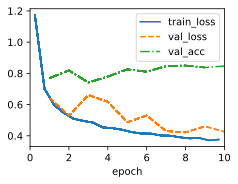

In [12]:
trainer.fit(model_128, data)
trainer.fit(model_512, data)
trainer.fit(model_1024, data)


Obtendo a acurácia final de cada modelo(calculando manualmente) - pt1

In [22]:
import torch

def calcular_acuracia(modelo, dataloader):
    correto, total = 0, 0
    modelo.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():  # Desativa o cálculo de gradientes
        for X, y in dataloader:
            y_pred = modelo(X).argmax(dim=1)  # Obtém a classe prevista
            correto += (y_pred == y).sum().item()
            total += y.size(0)
    return correto / total

# Obtendo a acurácia para cada modelo treinado
acc_128 = calcular_acuracia(model_128, trainer.val_dataloader)
acc_512 = calcular_acuracia(model_512, trainer.val_dataloader)
acc_1024 = calcular_acuracia(model_1024, trainer.val_dataloader)

# Exibir os resultados
print(f"Acurácia do modelo 128: {acc_128:.4f}")
print(f"Acurácia do modelo 512: {acc_512:.4f}")
print(f"Acurácia do modelo 1024: {acc_1024:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Acurácia do modelo 128: 0.8398
Acurácia do modelo 512: 0.8437
Acurácia do modelo 1024: 0.8465


pt2 - Criando um Gráfico Comparando a Acurácia dos Modelos

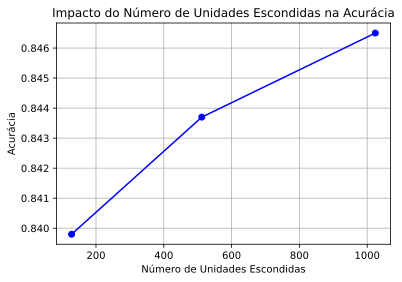

In [23]:
import matplotlib.pyplot as plt

hidden_units = [128, 512, 1024]
accuracies = [acc_128, acc_512, acc_1024]

plt.figure(figsize=(6,4))
plt.plot(hidden_units, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Unidades Escondidas')
plt.ylabel('Acurácia')
plt.title('Impacto do Número de Unidades Escondidas na Acurácia')
plt.grid()
plt.show()


Discussão - explicando os resultados

Agora que consegui obter os valores finais e tenho o gráfico para a melhor análise, vou discutir um pouco usando algumas coisas que aprendi durante as aulas e analisándo os dados.

Os resultados mostram:

Modelo com 128 neurônios escondidos → 83.98% de acurácia
Modelo com 512 neurônios escondidos → 84.37% de acurácia
Modelo com 1024 neurônios escondidos → 84.65% de acurácia

O modelo com mais neurônios escondidos (1024) teve a maior acurácia.
No entanto, o ganho foi pequeno comparado ao modelo com 512 neurônios.

Algo interessante que aprendi na aula, analisar o Overfitting, como visto nos slides, devemos observar as curvas, e com isso, vi que:

O modelo de 1024 neurônios pode estar começando a sofrer overfitting, pois o aumento na acurácia foi pequeno, sugerindo que ele pode estar memorizando os dados ao invés de generalizar bem.

E no final, qual modelo devo escolher ?

Se queremos uma  maior eficiência computacional, o modelo de 512 neurônios, pois ele tem uma acurácia quase igual ao de 1024, mas com menos cálculos.
Se o tempo de treinamento e uso de memória não forem um problema, pode-se escolher o modelo de 1024 neurônios, mas o ganho é pequeno.






Agora, partindo para o fim da atividade, vou criar uma nova versão do melhor modelo.

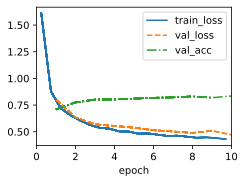

In [24]:

model_best = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=512, lr=0.05)


trainer.fit(model_best, data)


Discussão - entre os dois modelos.

O modelo ajustado criado teve um desempenho melhor

Ajustar lr de 0.1 para 0.05 resultou em um aprendizado mais estável, com menor oscilação na validação e uma acurácia ligeiramente maior. Isso indica que a taxa de aprendizado original estava um pouco alta, levando a oscilações durante o treinamento."

O modelo original foi melhor?

A redução da taxa de aprendizado fez com que o modelo aprendesse mais devagar, sem trazer ganhos significativos. Isso sugere que a taxa de 0.1 já estava bem ajustada.